download google takeout?



In [ ]:
var importer = require('../Core');

var listTakeouts = () => {
    return client
    .url('https://takeout.google.com/settings/takeout')
    .loginGoogle()
    .waitUntil(() => client.getUrl()
           .then(url => url.indexOf('privacy') > -1 || url.indexOf('takeout') > -1), 20000, '')
    .url('https://takeout.google.com/settings/takeout')
    .getAllXPath([
        '//*[@data-id]',
        {
            id: './@data-id',
            label: './/td[3]//text()'
        }
    ])
};

var takeoutProducts = (product) => {
    return client
    .url('https://takeout.google.com/settings/takeout/custom/' + product.id)
    .pause(1000)
    .click('//*[contains(@role, "button")][contains(., "Next")]')
    .pause(1000)
    .execute(() => {
        var el = document.evaluate(
            '//*[contains(., "Archive size")]/parent::*//*[contains(@role,"option")][contains(.,"2")]',
            document,
            null,
            XPathResult.FIRST_ORDERED_NODE_TYPE, null
        ).singleNodeValue;
        var event = document.createEvent('MouseEvents');
        event.initEvent('mousedown', true, true);
        el.dispatchEvent(event, true);
    })
    .pause(1000)
    // TODO: shorten this in to a utility command
    // doesn't work because of some weird css BS 
    // .click('//*[contains(@role, "option")][contains(., "50")]')
    .click('//*[contains(., "Archive size")]/parent::*//*[contains(@role,"listbox")]/div[3]//*[contains(@role,"option")][contains(.,"50")]')
    .click('//*[contains(@role, "button")][contains(., "Create archive")]')
    .waitUntil(() => client.isExisting('//tr[1]/td[last()]//*[contains(@data-download-uri, "takeout/download")]'), 120000, '')
    .click('//tr[1]/td[last()]//*[contains(@data-download-uri, "takeout/download")]')
    .pause(2000)
    .loginGoogle()
};

var downloadGoogleTakeout = (products) => {
    var regex = new RegExp(products, 'ig');
    var selectedProducts;
    return listTakeouts()
    .then(ids => {
        console.log(ids);
        return (selectedProducts = ids
        .map(k => ({
            id: k.id + '',
            label: k.label + ''
        }))
        .filter(k => k.id != '_gd' && (products.indexOf('all') > -1
                || k.id.match(regex) || k.label.match(regex))))
    })
    .then(() => {
        console.log(selectedProducts);
        return importer.runAllPromises(selectedProducts
        .map(p => (resolve) => {
            return takeoutProducts(p)
            .then(r => resolve(r))
            .catch(e => resolve(e))
        }))
    })
};
if (typeof client.downloadGoogleTakeout == 'undefined') {
    client.addCommand('downloadGoogleTakeout', downloadGoogleTakeout);
}
module.exports = downloadGoogleTakeout;
downloadGoogleTakeout;



order google takeout?



In [ ]:
var importer = require('../Core');

var runSeleniumCell, downloadGoogleTakeout;
var googleTakeout = (products = 'all?') => {
    return importer.interpretAll(['selenium cell'])
    .then(r => {
        runSeleniumCell = r[0].runInNewContext({});
        return runSeleniumCell([
            'log in google',
            'get all elements',
            'download google takeout'
        ]);
    })
    .then(r => {
        downloadGoogleTakeout = r[2];
        return downloadGoogleTakeout(products);
    })
    .then(r => {
        // TODO: save it in the project path?
        return r;
    })
};
module.exports = googleTakeout;
googleTakeout;



test google takeout



In [4]:
var importer = require('../Core');

$$.async();
var googleTakeout;
importer.interpretAll(['order google takeout'])
.then(r => {
    googleTakeout = r[0].runInNewContext();
    return googleTakeout('location|\\+1');
})
.then(r => $$.sendResult(r))
.catch(e => $$.sendError(e));



Already imported
[ 'import notebook.ipynb', 'interpret all notebooks.ipynb' ]
Already imported
[ 'import notebook.ipynb', 'interpret all notebooks.ipynb' ]
Already imported
[ 'import notebook.ipynb', 'interpret all notebooks.ipynb' ]
Initializing webdriver on localhost
Already imported
[ 'import notebook.ipynb', 'interpret all notebooks.ipynb' ]
[ { id: '_gd', label: [] },
  { id: 'plus_one', label: '+1s' },
  { id: 'android_pay', label: 'Android Pay' },
  { id: 'blogger', label: 'Blogger' },
  { id: 'bookmarks', label: 'Bookmarks' },
  { id: 'calendar', label: 'Calendar' },
  { id: 'chrome', label: 'Chrome' },
  { id: 'contacts', label: 'Contacts' },
  { id: 'drive', label: 'Drive' },
  { id: 'fit', label: 'Fit' },
  { id: 'plus_photos', label: 'Google Photos' },
  { id: 'books', label: 'Google Play Books' },
  { id: 'circles', label: 'Google+ Circles' },
  { id: 'plus_pages', label: 'Google+ Pages' },
  { id: 'stream', label: 'Google+ Stream' },
  { id: 'groups', label: 'Groups' },
 

[ { sessionId: '0e40688383a1057d9fa66dc005d85f04',
    status: 0,
    value: null },
  null ]

d3 stream my chrome history by category and site sub-divided?



2017-09-14T23:43:36.214Z
2016-09-20T19:06:38.087Z
Already imported
[ 'import notebook.ipynb', 'interpret all notebooks.ipynb' ]


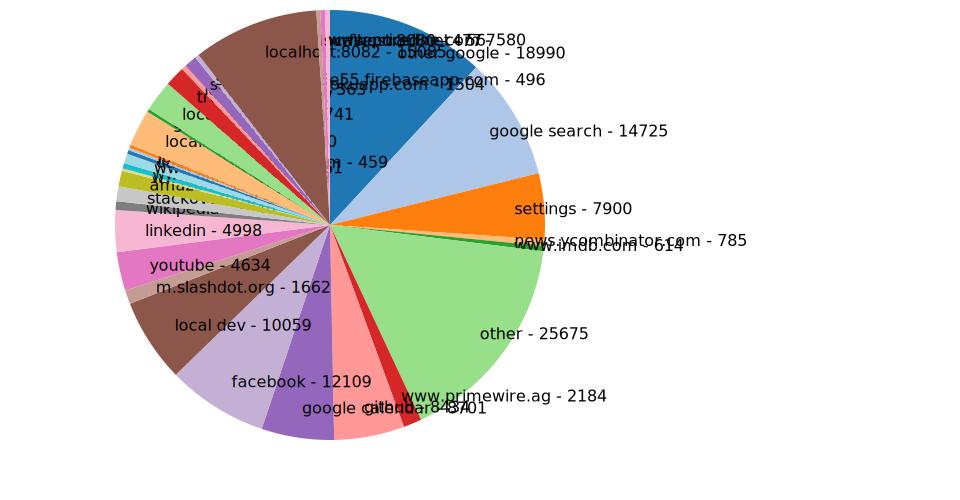

In [21]:
var fs = require('fs');
var importer = require('../Core');

var convertUnicode = (x) => {
    var r = /\\u([\d\w]{4})/gi;
    x = x.replace(r, function (match, grp) {
    return String.fromCharCode(parseInt(grp, 16)); } );
    return unescape(x);
}

var history = JSON.parse(fs.readFileSync('/Users/briancullinan/Downloads/Takeout 6/Chrome/BrowserHistory.json'));
var total = history['Browser History'].length;

console.log(new Date(Math.round(history['Browser History'][0].time_usec / 1000)))
console.log(new Date(Math.round(history['Browser History'][total-1].time_usec / 1000)))

var groupCounts = [];
var addSite = (label, value = 1) => {
    var site = groupCounts.filter(g => g.label == label)[0];
    if(typeof site == 'undefined') {
        groupCounts[groupCounts.length] = {
            label: label,
            value: value
        }
    } else {
        site.value += value;
    }
};

for(var i = 0; i < total; i++) {
    var uri = convertUnicode(history['Browser History'][i].url);
    if(uri.match('google.*?search')) { addSite('google search'); }
    else if(uri.match('calendar.*?google')) { addSite('google calendar'); }
    else if(uri.match('stackoverflow')) { addSite('stackoverflow'); }
    else if(uri.match('localhost:9090')) { addSite('local dev'); }
    else if(uri.match('linkedin')) { addSite('linkedin'); }
    else if(uri.match('google')) { addSite('other google'); }
    else if(uri.match('amazon')) { addSite('amazon'); }
    else if(uri.match('github')) { addSite('github'); }
    else if(uri.match('facebook')) { addSite('facebook'); }
    else if(uri.match('wikipedia')) { addSite('wikipedia'); }
    else if(uri.match('youtube')) { addSite('youtube'); }
    else if(uri.match('ftp:')) { addSite('ftp'); }
    else if(uri.match('chrome:|about:|native:|source:|file:|data:|extension:|intent:|content:|market:')) { addSite('settings'); }
    else {
        var domain = (/https?:\/\/(.*?)(\/|$)/ig).exec(uri);
        if(domain == null) {
            console.log(uri);
        }
        addSite(domain[1]);
    }
}

var oldGroups = groupCounts;
groupCounts = [];
for(var i = 0; i < oldGroups.length; i++) {
    if(oldGroups[i].value < 300) {
        addSite('other', oldGroups[i].value);
    } else {
        addSite(oldGroups[i].label, oldGroups[i].value);
    }
}

$$.async();
importer.interpretAll([
    'd3 pie chart'
])
.then(r => {
    d3PieChart = r[0].runInNewContext();
    return d3PieChart(groupCounts);
})
.then(r => $$.svg(r))
.catch(e => $$.sendError(e))

// TODO: use this chart instead? https://bl.ocks.org/mbostock/8d2112a115ad95f4a6848001389182fb
